## Importando bibliotecas necessárias

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Utilizado para data augmentation
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
tf.__version__

'2.6.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Carregamento da base de dados

In [ ]:
#Montando meu google drive com as imagens
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Dividindo os conjuntos de treino e teste com *data augmentation***

Conjunto de treinamento

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                                   rotation_range = 50,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True)

In [ ]:
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/data/datamining-ct/train',
                                                    target_size = (224, 224),
                                                    batch_size = 16,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

Found 311 images belonging to 2 classes.


In [ ]:
train_generator.n # Retorna o número de imagens

311

In [ ]:
train_generator.batch_size # Retorna o número do lote de atualizações das imagens, com intuito de atualizar os pesos da rede

16

In [ ]:
# Passo do treinamento
step_size_train = train_generator.n // train_generator.batch_size
step_size_train

19

Conjunto de teste

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [ ]:
test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/data/datamining-ct/test',
                                                  target_size = (224, 224),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 80 images belonging to 2 classes.


In [ ]:
step_size_test = test_generator.n // test_generator.batch_size
step_size_test

80

## Criando o modelo de Transfer Learning - ResNet50

In [ ]:
def create_model():

  base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top=False)

  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dense(256, activation='relu')(x)

  preds = tf.keras.layers.Dense(2, activation='softmax')(x)

  model = tf.keras.Model(inputs = base_model.input, outputs = preds)

  model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
model = create_model()
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_____________________________

In [ ]:
#Visualizando camadas
for i, layer in enumerate(model.layers):
  print(i, layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [ ]:
#Congelando camadas da ResNet50, para utilizar com os pesos já treinados
for layer in model.layers[:175]:
  layer.trainable = False

In [ ]:
#Descongelando a parte personalizada, criada acima com as camadas densas
for layer in model.layers[175:]:
  layer.trainable = True

In [ ]:
#Treinando a rede com os parâmetros
import pandas as pd

epochs = 100
loops = 1
history = {}

for i in range(loops):
  print('Ciclo: ', i+1)
  print()
  #model = create_model()
  history = model.fit_generator(generator = train_generator,
                              epochs = epochs,
                              steps_per_epoch = step_size_train,
                              validation_data = test_generator,
                              validation_steps = step_size_test,
                              verbose = 0)

Ciclo:  1



/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


# Avaliação da rede

## Gráficos

In [ ]:
#Acurácia
np.mean(history.history['val_accuracy'])

0.5741250002384186

In [ ]:
np.std(history.history['val_accuracy'])

0.0658894659858155

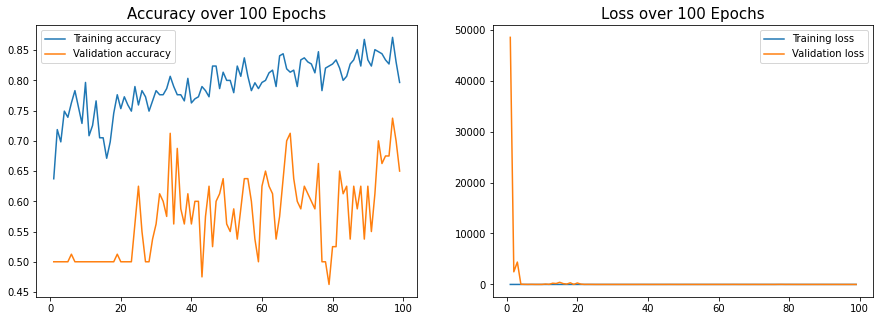

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = 100
def plot_acc_loss(history, epochs):

 acc = history.history['accuracy']
 loss = history.history['loss']
 val_acc = history.history['val_accuracy']
 val_loss = history.history['val_loss']
 plt.figure(figsize=(15, 5))

 plt.subplot(121)
 plt.plot(range(1,epochs), acc[1:], label='Training accuracy')
 plt.plot(range(1,epochs), val_acc[1:], label='Validation accuracy')
 plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
 plt.legend()
 #plt.grid(True)

 plt.subplot(122)
 plt.plot(range(1,epochs), loss[1:], label='Training loss')
 plt.plot(range(1,epochs), val_loss[1:], label='Validation loss')
 plt.title('Loss over ' + str(epochs) +  ' Epochs', size=15)
 plt.legend();
 #plt.grid(True)
 plt.show()

 
plot_acc_loss(history, epochs)
plt.savefig('curvas-ct.png', dpi=500) 

## Previsões

In [ ]:
#Pega todas as imagens do teste
filenames = test_generator.filenames
filenames

['COVID-19/2020.02.10.20021584-p6-52_11.png',
 'COVID-19/2020.02.10.20021584-p6-52_14.png',
 'COVID-19/2020.02.10.20021584-p6-52_3.png',
 'COVID-19/2020.02.10.20021584-p6-52_4.png',
 'COVID-19/2020.02.10.20021584-p6-52_8.png',
 'COVID-19/2020.02.11.20021493-p16-109_2.png',
 'COVID-19/2020.02.11.20022053-p12-67_0.png',
 'COVID-19/2020.02.11.20022053-p12-67_2.png',
 'COVID-19/2020.02.13.20022673-p13-77_0.png',
 'COVID-19/2020.02.13.20022673-p13-77_2.png',
 'COVID-19/2020.02.22.20024927-p19-68_5.png',
 'COVID-19/2020.02.22.20024927-p20-70_0.png',
 'COVID-19/2020.02.22.20024927-p20-70_1.png',
 'COVID-19/2020.02.22.20024927-p20-70_2.png',
 'COVID-19/2020.02.25.20021568-p24-111_2.png',
 'COVID-19/2020.03.03.20030353-p17-106_2.png',
 'COVID-19/2020.03.03.20030775-p11-91.png',
 'COVID-19/2020.03.04.20031047-p12-81_0.png',
 'COVID-19/2020.03.09.20033118-p20-93_0.png',
 'COVID-19/2020.03.09.20033118-p20-93_1.png',
 'COVID-19/2020.03.09.20033118-p20-93_2.png',
 'COVID-19/2020.03.10.20032136-p34-1

In [ ]:
len(filenames)

80

In [ ]:
predictions = model.predict(test_generator, steps = len(filenames))

In [ ]:
#Retorna as probabilidades
predictions

array([[4.95449128e-03, 9.95045543e-01],
       [4.22753133e-02, 9.57724690e-01],
       [6.19237684e-03, 9.93807614e-01],
       [1.86504200e-02, 9.81349647e-01],
       [1.80559531e-01, 8.19440484e-01],
       [3.96849513e-02, 9.60314989e-01],
       [9.99463260e-01, 5.36740990e-04],
       [2.14993522e-01, 7.85006464e-01],
       [9.56569552e-01, 4.34304513e-02],
       [9.32694554e-01, 6.73055053e-02],
       [8.50755095e-01, 1.49244905e-01],
       [5.17512619e-01, 4.82487440e-01],
       [4.29710090e-01, 5.70289850e-01],
       [7.97737420e-01, 2.02262536e-01],
       [5.50595641e-01, 4.49404299e-01],
       [9.63466823e-01, 3.65331285e-02],
       [4.31741357e-01, 5.68258643e-01],
       [9.94333148e-01, 5.66681428e-03],
       [8.86339724e-01, 1.13660276e-01],
       [4.84223872e-01, 5.15776098e-01],
       [3.50961894e-01, 6.49038076e-01],
       [2.65419930e-02, 9.73457992e-01],
       [1.32095695e-01, 8.67904365e-01],
       [7.65184965e-03, 9.92348194e-01],
       [2.318766

In [ ]:
predictions2 = []
for i in range(len(predictions)):
  predictions2.append(np.argmax(predictions[i]))

In [ ]:
predictions2

[1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1]

In [ ]:
#Fazendo previsão com as imagens reais
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
test_generator.class_indices

{'COVID-19': 0, 'Non-COVID-19': 1}

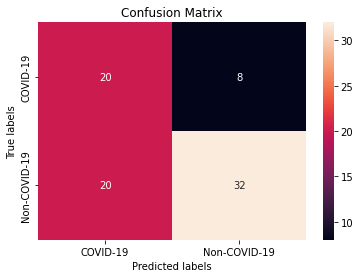

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt     
from sklearn.metrics import accuracy_score, confusion_matrix


cm = confusion_matrix(predictions2, test_generator.classes)

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

ax.xaxis.set_ticklabels(['COVID-19', 'Non-COVID-19']); 
ax.yaxis.set_ticklabels(['COVID-19', 'Non-COVID-19']);
plt.savefig('cm-ct.png', dpi=500)

In [ ]:
accuracy_score(predictions2, test_generator.classes)

0.65

## Plot Curva ROC

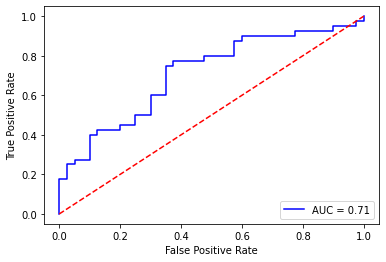

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

#Recuperando probabilidade da saída, somente da coluna
pred = predictions[:, 1]

#Resultados verdadeiros
y = test_generator.classes

fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
'''
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='')
display.plot()
plt.show()
'''
#plt.title('ROC curve CT images')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--r')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('roc-ct.png', dpi=500)
plt.show()